In [1]:
import numpy as np
import matplotlib.pyplot as plt

from noise import Parameters
from noise.sdesolve import feynman_y_by_signal, signal_make
from noise.analytic import fit_to_feynman_y, feynman_y_model

# Creating the system parameters

In this case we create a -5000 pcm subcritical system with a generation time of $50 \mu s$, a source with a yield of $10^6$ neutrons per second, and where the multiplicity distribution has an average of 2.42 and a second moment of 6. The detection rate is set at $10^{-4}$ detections per second on average for each neutron.

In [2]:
par = Parameters.from_dubi(-500e-5, 5e-5, 1e6, 2.42, 6., 1e-4)

# Creating a random number generator

We are using NumPy's random number generators. The choice of the seed of 48 here is arbitrary. You can and should replace this as required.

When running multiple experiments, you will need multiple number random generators, otherwise your results will not be independent of one another

In [3]:
generator = np.random.Generator(np.random.SFC64(48))

# Creating a single Signal

## Deciding on the times at which detections should be computed.

Here we choose to take 1ms steps for 10 minutes.

In [4]:
experiment_time = 600
ts = np.linspace(0, experiment_time, experiment_time*1000)

## Running the signal generator

In [5]:
detections = signal_make(ts, par, rand_gen=generator)

Let's see our detections:

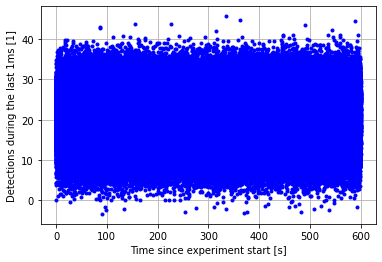

In [6]:
plt.plot(ts, detections, '.b')
plt.xlabel('Time since experiment start [s]')
plt.ylabel('Detections during the last 1ms [1]')
plt.grid()

This is and should have been a mess. A histogram would show that this is practically normally distributed. 

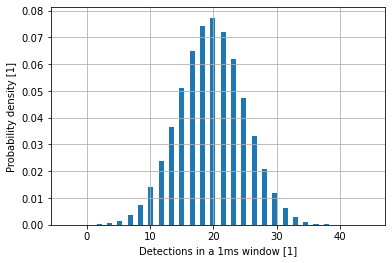

In [7]:
histv, edges = np.histogram(detections, 30, density=True)
plt.bar(edges[:-1], histv, align='edge')
plt.xlabel('Detections in a 1ms window [1]')
plt.ylabel('Probability density [1]')
plt.grid()

It is, however, relatively smooth, since the detections are solved sequentially in time.
If we were to solve the detections analytically from the SDE and sample from the normal solution it yields, the result in each time would be independent of our sample of previous times.

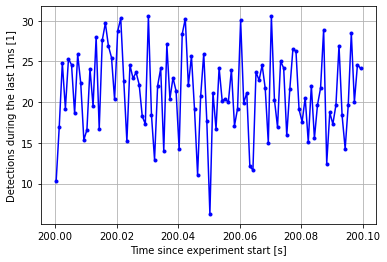

In [8]:
mask = (200 < ts) & (ts < 200.1)
plt.plot(ts[mask], detections[mask], '.-b')
plt.xlabel('Time since experiment start [s]')
plt.ylabel('Detections during the last 1ms [1]')
plt.grid()

# Creating a Feynman-Y curve for a simulated experiment

## Deciding on an experiment length

Let's take 10 minutes again:

In [9]:
t = 600.

## Create the Feynman-Y curve

In [10]:
window_sizes, fy, sigma = feynman_y_by_signal(par, t, rand_gen=generator)

## Filter down the results to 0.1s

In [11]:
mask = (window_sizes <= 1e-1)
tfit, cfit, sfit = window_sizes[mask], fy[mask], sigma[mask]

## Fit the results to a Feynman-Y curve

In [12]:
popt, pcov = fit_to_feynman_y(tfit, cfit, sfit)

Let's see the fit. 

The errors are only estimated to be proportional to the actual statistical error, so we magnify them to make their relative size for different window sizes more easily visible.

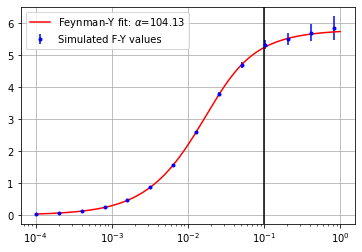

In [13]:
plt.errorbar(window_sizes, fy, yerr=10*sigma, fmt='.b', label='Simulated F-Y values')
x = np.logspace(-4, 0, 400)
y = feynman_y_model(x, *popt)
plt.plot(x, y, '-r', label=fr'Feynman-Y fit: $\alpha$={popt[1]:.2f}')
plt.axvline(0.1, color='k')
plt.xscale('log')
plt.legend()
plt.grid()